### Initial settings

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path_to_drive = '/content/drive/MyDrive/data/'
path_to_file = path_to_drive + 'weatherAUS.csv'

In [ ]:
!apt update

In [4]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://dlcdn.apache.org/spark/spark-3.2.0/spark-3.2.0-bin-hadoop3.2.tgz
!tar xf spark-3.2.0-bin-hadoop3.2.tgz

In [5]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.0-bin-hadoop3.2"

In [6]:
!pip install -q findspark

In [7]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").appName("Classification-Australia-Weather").getOrCreate()

### Dataset ☔

**Rain in Australia**

Predict next-day rain in Australia

This dataset contains about 10 years of daily weather observations from many locations across Australia.

RainTomorrow is the target variable to predict. It means -- did it rain the next day, Yes or No? This column is Yes if the rain for that day was 1mm or more.

**Column meanings:**

`Date` - Day of the month

`Location` - Place where observations were collected

`MinTemp` - Minimum temperature in the 24 hours to 9am. Sometimes only known to the nearest whole degree.

`MaxTemp` - Maximum temperature in the 24 hours to 9am. Sometimes only known to the nearest whole degree.

`Rainfall` - Precipitation (rainfall) in the 24 hours to 9am. Sometimes only known to the nearest whole millimetre.

`Evaporation` - "Class A" pan evaporation in the 24 hours to 9am

`Sunshine` - 	Bright sunshine in the 24 hours to midnight

`Max wind gust`	
* Dirn -	Direction of strongest gust in the 24 hours to midnight
* Spd -	Speed of strongest wind gust in the 24 hours to midnight

`9 am`
* Temp - Temperature at 9 am
* Humidity - Relative humidity at 9 am
* Cloud -	Fraction of sky obscured by cloud at 9 am
* Wind Direction - Wind direction averaged over 10 minutes prior to 9 am
* Wind Speed - Wind speed averaged over 10 minutes prior to 9 am
* Pressure - Atmospheric pressure reduced to mean sea level at 9 am

`3 pm`
* Temp - Temperature at 3 pm
* Humidity - Relative humidity at 3 pm
* Cloud - Fraction of sky obscured by cloud at 3 pm
* Wind Direction - Wind direction averaged over 10 minutes prior to 3 pm
* Wind Speed - Wind speed averaged over 10 minutes prior to 3 pm
* Pressure - Atmospheric pressure reduced to mean sea level at 3 pm








### Classification with Spark

In [198]:
from pyspark.sql.functions import isnan, when, count, col
from pyspark.sql.types import StructType, StringType, FloatType, DateType

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_theme()

In [199]:
schema = StructType() \
      .add("Date", DateType(), True) \
      .add("Location", StringType(), True) \
      .add("MinTemp", FloatType(), True) \
      .add("MaxTemp", FloatType(), True) \
      .add("Rainfall", FloatType(), True) \
      .add("Evaporation", FloatType(), True) \
      .add("Sunshine", FloatType(), True) \
      .add("WindGustDir", StringType(),True) \
      .add("WindGustSpeed", FloatType(), True) \
      .add("WindDir9am", StringType(), True) \
      .add("WindDir3pm", StringType(), True) \
      .add("WindSpeed9am", FloatType(), True) \
      .add("WindSpeed3pm", FloatType(), True) \
      .add("Humidity9am", FloatType(), True) \
      .add("Humidity3pm", FloatType(), True) \
      .add("Pressure9am", FloatType(), True) \
      .add("Pressure3pm", FloatType(), True) \
      .add("Cloud9am", FloatType(), True) \
      .add("Cloud3pm", FloatType(), True) \
      .add("Temp9am", FloatType(), True) \
      .add("Temp3pm", FloatType(), True) \
      .add("RainToday", StringType(), True) \
      .add("RainTomorrow", StringType(), True)

In [200]:
weather_df = spark.read.option("header", True).csv(path=path_to_file, schema=schema).cache()

In [201]:
print((weather_df.count(), len(weather_df.columns)))

(145460, 23)


In [202]:
weather_df.show(5)

+----------+--------+-------+-------+--------+-----------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+--------+--------+-------+-------+---------+------------+
|      Date|Location|MinTemp|MaxTemp|Rainfall|Evaporation|Sunshine|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|Cloud9am|Cloud3pm|Temp9am|Temp3pm|RainToday|RainTomorrow|
+----------+--------+-------+-------+--------+-----------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+--------+--------+-------+-------+---------+------------+
|2008-12-01|  Albury|   13.4|   22.9|     0.6|       null|    null|          W|         44.0|         W|       WNW|        20.0|        24.0|       71.0|       22.0|     1007.7|     1007.1|     8.0|    null|   16.9|   21.8|       No|          No|
|2008-12-02|

In [203]:
weather_df.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Location: string (nullable = true)
 |-- MinTemp: float (nullable = true)
 |-- MaxTemp: float (nullable = true)
 |-- Rainfall: float (nullable = true)
 |-- Evaporation: float (nullable = true)
 |-- Sunshine: float (nullable = true)
 |-- WindGustDir: string (nullable = true)
 |-- WindGustSpeed: float (nullable = true)
 |-- WindDir9am: string (nullable = true)
 |-- WindDir3pm: string (nullable = true)
 |-- WindSpeed9am: float (nullable = true)
 |-- WindSpeed3pm: float (nullable = true)
 |-- Humidity9am: float (nullable = true)
 |-- Humidity3pm: float (nullable = true)
 |-- Pressure9am: float (nullable = true)
 |-- Pressure3pm: float (nullable = true)
 |-- Cloud9am: float (nullable = true)
 |-- Cloud3pm: float (nullable = true)
 |-- Temp9am: float (nullable = true)
 |-- Temp3pm: float (nullable = true)
 |-- RainToday: string (nullable = true)
 |-- RainTomorrow: string (nullable = true)



Dataset contains NA values as missing values so replace it with None for Pyspark

In [204]:
weather_df = weather_df.replace({'NA': None})

Target variable may contain missing value so drop such columns

In [205]:
weather_df = weather_df.na.drop(subset=["RainTomorrow"])

#### Explore `RainTomorrow` target variable

In [206]:
rainTomorrow = weather_df.select("RainTomorrow").toPandas()

In [207]:
rainTomorrow['RainTomorrow'].nunique()

2

In [208]:
rainTomorrow['RainTomorrow'].unique()

array(['No', 'Yes'], dtype=object)

In [209]:
rainTomorrow['RainTomorrow'].value_counts()

No     110316
Yes     31877
Name: RainTomorrow, dtype: int64

In [210]:
rainTomorrow['RainTomorrow'].value_counts() / weather_df.count()

No     0.775819
Yes    0.224181
Name: RainTomorrow, dtype: float64

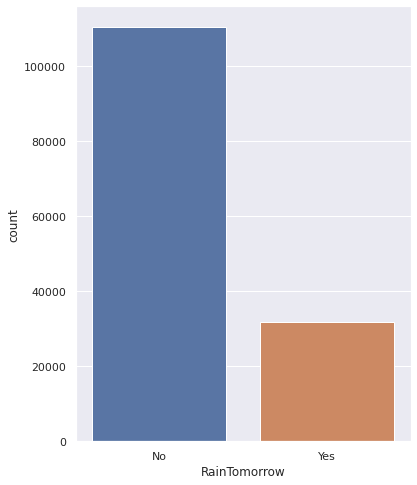

In [211]:
f, ax = plt.subplots(figsize=(6, 8))
ax = sns.countplot(x="RainTomorrow", data=rainTomorrow)
plt.show()

`RainTomorrow` contains two classes Yes and No. Classes are not balanced, No class prevails over Yes.

#### Explore categorical variables

In [212]:
categorical_columns_names = [column[0] for column in weather_df.dtypes if column[1] == 'string']

In [213]:
categorical_columns = weather_df.select(categorical_columns_names).toPandas()

In [214]:
categorical_columns.isnull().sum()

Location            0
WindGustDir      9330
WindDir9am      10013
WindDir3pm       3778
RainToday        1406
RainTomorrow        0
dtype: int64

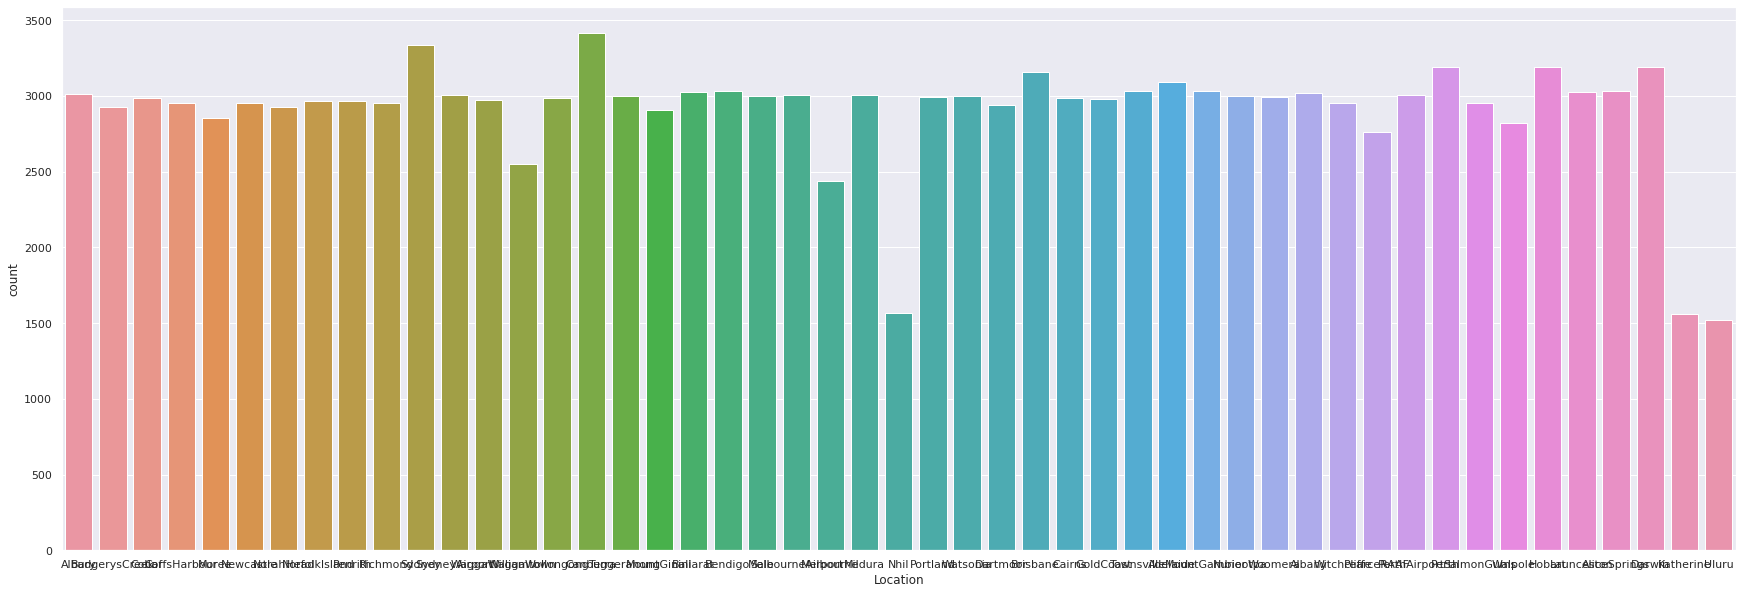

In [215]:
fig, ax = plt.subplots(figsize=(30, 10))

ax = sns.countplot(x="Location", data=categorical_columns)
plt.show()

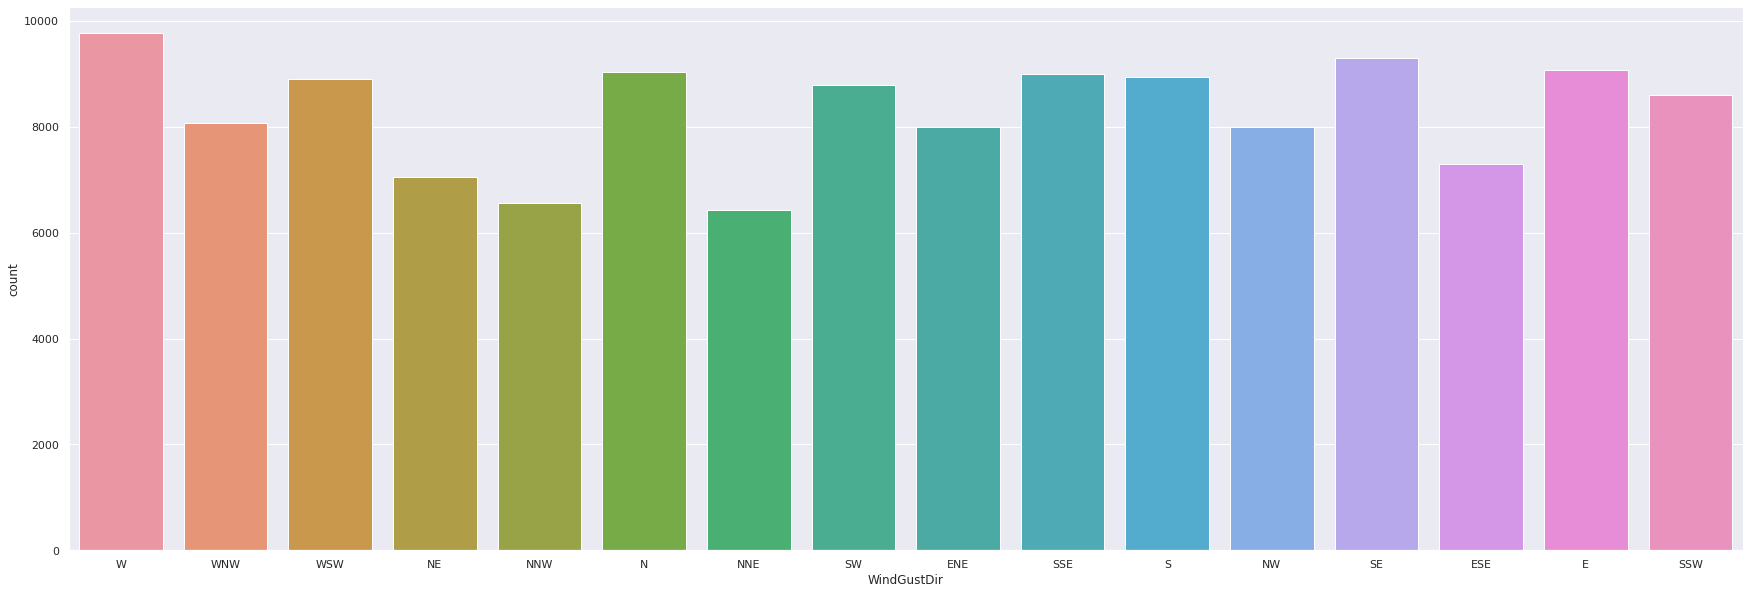

In [216]:
fig, ax = plt.subplots(figsize=(30, 10))

ax = sns.countplot(x="WindGustDir", data=categorical_columns)
plt.show()

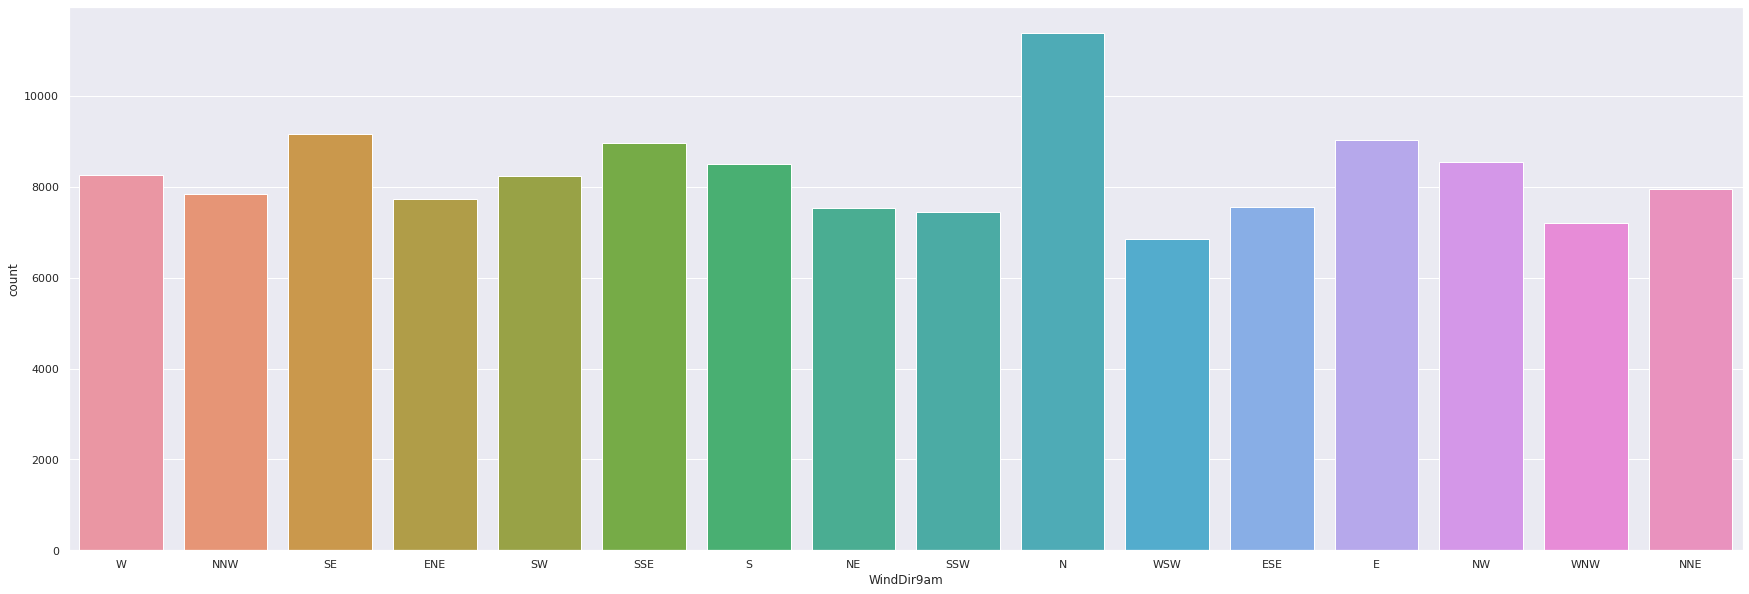

In [217]:
fig, ax = plt.subplots(figsize=(30, 10))

ax = sns.countplot(x="WindDir9am", data=categorical_columns)
plt.show()

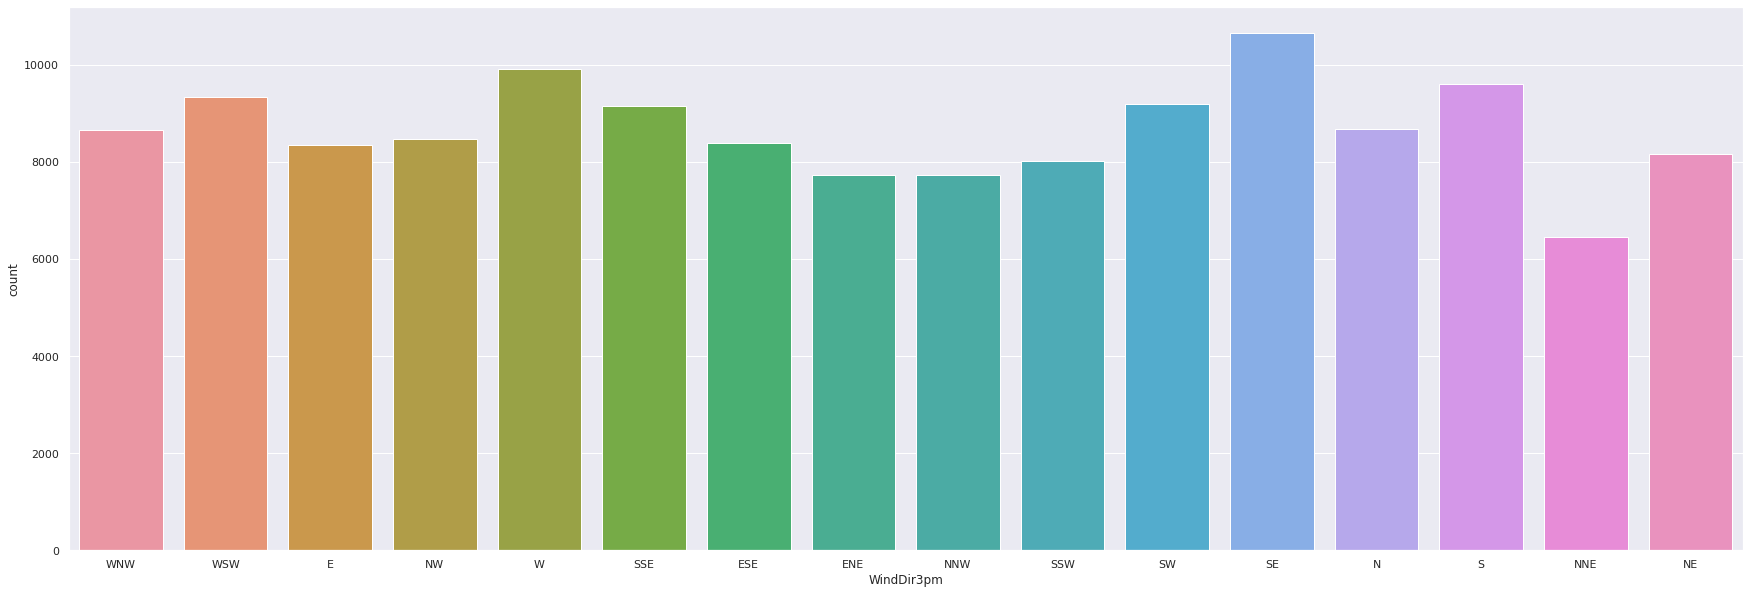

In [218]:
fig, ax = plt.subplots(figsize=(30, 10))

sns.countplot(x="WindDir3pm", data=categorical_columns)
plt.show()

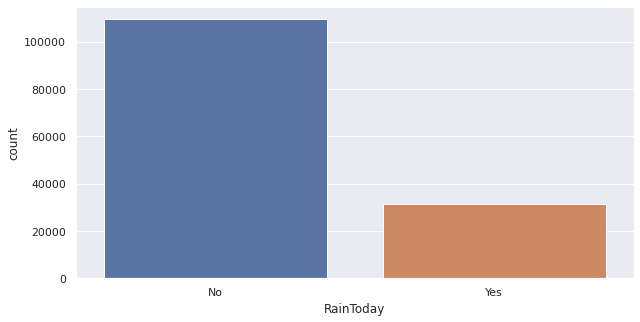

In [219]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.countplot(x="RainToday", data=categorical_columns)
plt.show()

**Number of labels:**

Check number of labels and preprocess columns with many different values

In [220]:
for column in categorical_columns_names:
    print(column, ' contains ', len(categorical_columns[column].unique()), ' labels')

Location  contains  49  labels
WindGustDir  contains  17  labels
WindDir9am  contains  17  labels
WindDir3pm  contains  17  labels
RainToday  contains  3  labels
RainTomorrow  contains  2  labels


Number of labels in categorical columns is acceptable, but there are a lot of values in `Date` column due to it represent date of observation. So we can split this feature to year, month, day and day of week.

In [221]:
from pyspark.sql.functions import year, month, dayofmonth, dayofweek

In [222]:
weather_df = (weather_df.withColumn("Year", year("Date")).withColumn("Month", month("Date")).withColumn("Day", dayofweek("Date")).withColumn("DayOfWeek", dayofweek("Date")))

In [223]:
weather_df = weather_df.drop('Date')

In [224]:
weather_df.show(5)

+--------+-------+-------+--------+-----------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+--------+--------+-------+-------+---------+------------+----+-----+---+---------+
|Location|MinTemp|MaxTemp|Rainfall|Evaporation|Sunshine|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|Cloud9am|Cloud3pm|Temp9am|Temp3pm|RainToday|RainTomorrow|Year|Month|Day|DayOfWeek|
+--------+-------+-------+--------+-----------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+--------+--------+-------+-------+---------+------------+----+-----+---+---------+
|  Albury|   13.4|   22.9|     0.6|       null|    null|          W|         44.0|         W|       WNW|        20.0|        24.0|       71.0|       22.0|     1007.7|     1007.1|     8.0|    null|   16.9|   21.8|     

### Explore numerical variables

In [225]:
numerical_columns_names = [column[0] for column in weather_df.dtypes if column[1] == 'float']

print('There are {} numerical variables\n'.format(len(numerical_columns_names)))

print('The numerical variables are :', numerical_columns_names)

There are 16 numerical variables

The numerical variables are : ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']


In [226]:
numerical_columns = weather_df.select(numerical_columns_names).toPandas()

In [227]:
numerical_columns.isnull().sum()

MinTemp            637
MaxTemp            322
Rainfall          1406
Evaporation      60843
Sunshine         67816
WindGustSpeed     9270
WindSpeed9am      1348
WindSpeed3pm      2630
Humidity9am       1774
Humidity3pm       3610
Pressure9am      14014
Pressure3pm      13981
Cloud9am         53657
Cloud3pm         57094
Temp9am            904
Temp3pm           2726
dtype: int64

In [228]:
numerical_columns.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,141556.000000,141871.000000,140787.000000,81350.000000,74377.000000,132923.000000,140845.000000,139563.000000,140419.000000,138583.000000,128179.000000,128212.000000,88536.000000,85099.000000,141289.000000,139467.000000
mean,12.186475,23.226818,2.350023,5.469787,7.624741,39.984291,14.001988,18.637575,68.843811,51.482605,1017.653564,1015.254700,4.437190,4.503167,16.987465,21.687134
std,6.403172,7.117685,8.468378,4.188550,3.781243,13.587051,8.893332,8.803850,19.050930,20.798422,7.105008,7.036356,2.886452,2.720423,6.492784,6.937523
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.500000,977.099976,0.000000,0.000000,-7.200000,-5.400000
25%,7.600000,17.900000,0.000000,2.600000,4.900000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.900024,1010.400024,1.000000,2.000000,12.300000,16.600000
50%,12.000000,22.600000,0.000000,4.800000,8.500000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.599976,1015.200012,5.000000,5.000000,16.700001,21.100000
75%,16.799999,28.200001,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.400024,1020.000000,7.000000,7.000000,21.600000,26.400000
max,33.900002,48.099998,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.000000,1039.599976,9.000000,9.000000,40.200001,46.700001


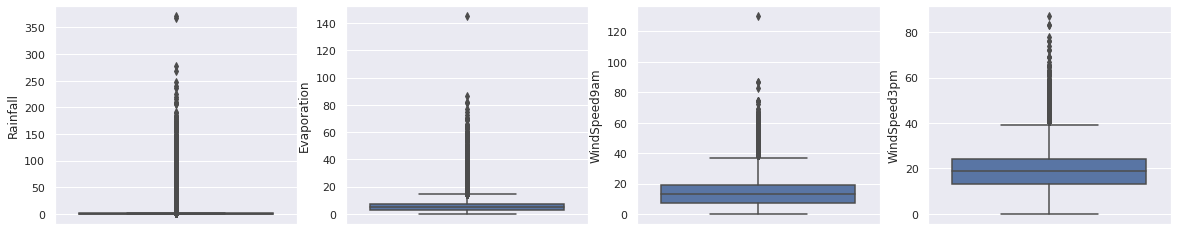

In [229]:
fig, axs = plt.subplots(ncols=4, figsize=(20, 4))

sns.boxplot(data=numerical_columns, y='Rainfall', ax=axs[0])
sns.boxplot(data=numerical_columns, y='Evaporation', ax=axs[1])
sns.boxplot(data=numerical_columns, y='WindSpeed9am', ax=axs[2])
sns.boxplot(data=numerical_columns, y='WindSpeed3pm', ax=axs[3])

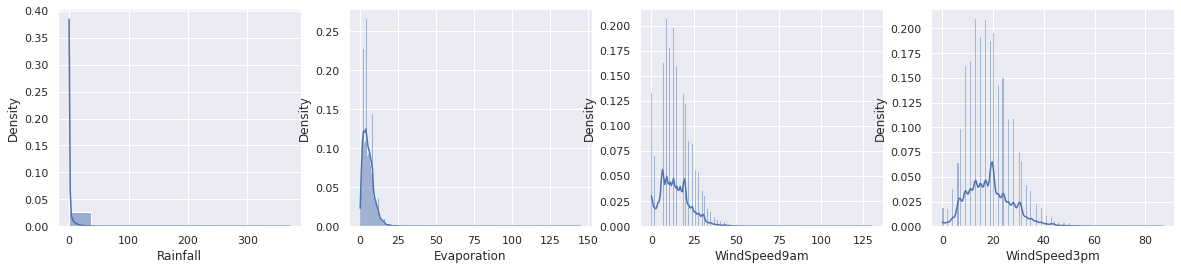

In [230]:
fig, axs = plt.subplots(ncols=4, figsize=(20, 4))

sns.histplot(data=numerical_columns, x='Rainfall', stat="density", kde=True, common_norm=False, ax=axs[0], bins=10)
sns.histplot(data=numerical_columns, x='Evaporation', stat="density", kde=True, common_norm=False, ax=axs[1])
sns.histplot(data=numerical_columns, x='WindSpeed9am', stat="density", kde=True, common_norm=False, ax=axs[2])
sns.histplot(data=numerical_columns, x='WindSpeed3pm', stat="density", kde=True, common_norm=False, ax=axs[3])

Data in numeric columns contains outliers and missing values. So replace missing values with median.

In [231]:
from pyspark.ml.feature import Imputer

In [232]:
imputer = Imputer(
    inputCols=numerical_columns_names, 
    outputCols=numerical_columns_names
    ).setStrategy("median")

In [233]:
weather_df = imputer.fit(weather_df).transform(weather_df)

In [234]:
weather_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in weather_df.columns]).show()

+--------+-------+-------+--------+-----------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+--------+--------+-------+-------+---------+------------+----+-----+---+---------+
|Location|MinTemp|MaxTemp|Rainfall|Evaporation|Sunshine|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|Cloud9am|Cloud3pm|Temp9am|Temp3pm|RainToday|RainTomorrow|Year|Month|Day|DayOfWeek|
+--------+-------+-------+--------+-----------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+--------+--------+-------+-------+---------+------------+----+-----+---+---------+
|       0|      0|      0|       0|          0|       0|       9330|            0|     10013|      3778|           0|           0|          0|          0|          0|          0|       0|       0|      0|      0|     

### Classification

#### Data preparation

In [235]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, IndexToString, VectorIndexer

In [236]:
def get_dummy(df, categorical_columns, numerical_columns, target_column):

    indexers = [StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c), handleInvalid='keep') for c in categorical_columns]

    encoders = [OneHotEncoder(inputCol=indexer.getOutputCol(),
                outputCol="{0}_encoded".format(indexer.getOutputCol()),
                handleInvalid='keep',
                dropLast=False)
                for indexer in indexers]

    assembler = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in encoders]
                                + numerical_columns, outputCol="features")

    pipeline = Pipeline(stages=indexers + encoders + [assembler])

    model=pipeline.fit(df)
    data = model.transform(df)

    data = data.withColumn('label', col(target_column))

    return data.select('features','label')

In [237]:
features_columns = categorical_columns_names[:-1]
numerical_columns_names += ['Year', 'Month', 'Day', 'DayOfWeek']

In [238]:
data_for_classification = get_dummy(weather_df, features_columns, numerical_columns_names, 'RainTomorrow')

In [239]:
data_for_classification.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(129,[14,51,75,94...|   No|
|(129,[14,60,78,90...|   No|
|(129,[14,57,75,90...|   No|
|(129,[14,64,70,97...|   No|
|(129,[14,51,79,95...|   No|
+--------------------+-----+
only showing top 5 rows



In [240]:
label_indexer = StringIndexer(inputCol='label',
                             outputCol='indexedLabel').fit(data_for_classification)
label_indexer.transform(data_for_classification).show(5, True)

+--------------------+-----+------------+
|            features|label|indexedLabel|
+--------------------+-----+------------+
|(129,[14,51,75,94...|   No|         0.0|
|(129,[14,60,78,90...|   No|         0.0|
|(129,[14,57,75,90...|   No|         0.0|
|(129,[14,64,70,97...|   No|         0.0|
|(129,[14,51,79,95...|   No|         0.0|
+--------------------+-----+------------+
only showing top 5 rows



In [241]:
feature_indexer=VectorIndexer(inputCol="features", 
                             outputCol="indexedFeatures",
                             handleInvalid="keep").fit(data_for_classification)
feature_indexer.transform(data_for_classification).show(5, True)

+--------------------+-----+--------------------+
|            features|label|     indexedFeatures|
+--------------------+-----+--------------------+
|(129,[14,51,75,94...|   No|(129,[14,51,75,94...|
|(129,[14,60,78,90...|   No|(129,[14,60,78,90...|
|(129,[14,57,75,90...|   No|(129,[14,57,75,90...|
|(129,[14,64,70,97...|   No|(129,[14,64,70,97...|
|(129,[14,51,79,95...|   No|(129,[14,51,79,95...|
+--------------------+-----+--------------------+
only showing top 5 rows



In [242]:
(training_data, test_data) = data_for_classification.randomSplit([0.7, 0.3])

In [243]:
training_data.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(129,[0,51,69,88,...|   No|
|(129,[0,51,69,88,...|  Yes|
|(129,[0,51,69,88,...|   No|
|(129,[0,51,69,88,...|   No|
|(129,[0,51,69,90,...|   No|
+--------------------+-----+
only showing top 5 rows



In [244]:
test_data.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(129,[0,51,69,95,...|   No|
|(129,[0,51,70,88,...|   No|
|(129,[0,51,70,88,...|   No|
|(129,[0,51,70,94,...|   No|
|(129,[0,51,70,100...|  Yes|
+--------------------+-----+
only showing top 5 rows



In [245]:
label_converter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=label_indexer.labels)

#### Make classifications

In [246]:
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, GBTClassifier, NaiveBayes

In [247]:
decision_tree = DecisionTreeClassifier(labelCol='indexedLabel', featuresCol='indexedFeatures')

In [248]:
pipeline_decision_tree = Pipeline(stages=[label_indexer, feature_indexer, decision_tree, label_converter])

In [249]:
model_decision_tree = pipeline_decision_tree.fit(training_data)

In [250]:
predictions_decision_tree = model_decision_tree.transform(test_data)

In [251]:
random_forest = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=30)

In [252]:
pipeline_random_forest = Pipeline(stages=[label_indexer, feature_indexer, random_forest, label_converter])

In [253]:
model_random_forest = pipeline_random_forest.fit(training_data)

In [254]:
predictions_random_forest = model_random_forest.transform(test_data)

In [255]:
gbt = GBTClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", maxIter=5, maxDepth=2)

In [256]:
pipeline_gbt = Pipeline(stages=[label_indexer, feature_indexer, gbt, label_converter])

In [257]:
model_gbt = pipeline_gbt.fit(training_data)

In [258]:
predictions_gbt = model_gbt.transform(test_data)

#### Evaluation

In [259]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import pandas as pd

In [260]:
evaluator = BinaryClassificationEvaluator(labelCol="indexedLabel", rawPredictionCol="prediction")

In [261]:
evaluations = []

In [262]:
evaluations.append(('Decision Tree', 
                    evaluator.evaluate(predictions_decision_tree), 
                    evaluator.evaluate(predictions_decision_tree, {evaluator.metricName: "areaUnderPR"})))
evaluations.append(('Random Forest',
                    evaluator.evaluate(predictions_random_forest),
                    evaluator.evaluate(predictions_random_forest, {evaluator.metricName: "areaUnderPR"})))
evaluations.append(('GBT',
                    evaluator.evaluate(predictions_gbt),
                    evaluator.evaluate(predictions_gbt, {evaluator.metricName: "areaUnderPR"})))

In [263]:
columns=['Algorithm', 'Under ROC', 'Under Precison Recall']

In [264]:
evaluations_data = pd.DataFrame.from_records(evaluations, columns=columns)

In [265]:
evaluations_data_melted = pd.melt(evaluations_data, id_vars=columns[0],
                                  var_name="Evaluation type", value_name="Evaluation")

In [266]:
evaluations_data_melted

,Algorithm,Evaluation type,Evaluation
0,Decision Tree,Under ROC,0.681450
1,Random Forest,Under ROC,0.610912
2,GBT,Under ROC,0.670492
3,Decision Tree,Under Precison Recall,0.595562
4,Random Forest,Under Precison Recall,0.594250
5,GBT,Under Precison Recall,0.579193


Text(0.5, 1.0, 'Оценка работы алгоритмов')

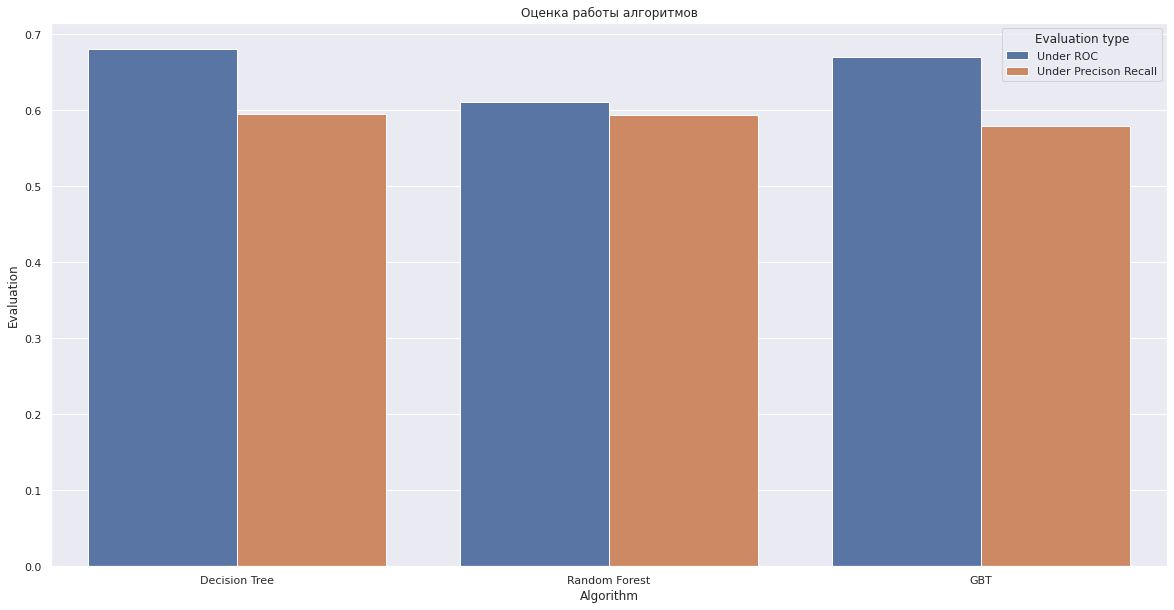

In [267]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.barplot(x=columns[0], y="Evaluation", hue="Evaluation type", data=evaluations_data_melted, ax=ax)
ax.set_title('Оценка работы алгоритмов')